In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv1D, BatchNormalization, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

sns.set(style="darkgrid")

# ---------------- User parameters ----------------
CSV_PATH = "BTC-2020min.csv"     
WINDOW = 100                  
TEST_RATIO = 0.2             
BATCH_SIZE = 128
FINAL_EPOCHS = 20
SAVE_PATH = "best_btc2020_model(numhead8_conv).h5"
VERBOSE = 1
# --------------------------------------------------

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and sort data
df = pd.read_csv(CSV_PATH, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# Drop rows with missing crucial data, process base features
df = df.dropna(subset=["close", "Volume USD"]).copy()
df["close"] = df["close"].astype(float)
df["log_close"] = np.log(df["close"])
df["logret"] = df["log_close"].diff().fillna(0.0)

# Split indices for train, val, test (dates or explicit indices)
train_end_idx = int(len(df) * 0.7)
val_end_idx = int(len(df) * 0.85)

# Split data chronologically before feature engineering!
df_train = df.loc[:train_end_idx].copy()
df_val = df.loc[train_end_idx + 1 : val_end_idx].copy()
df_test = df.loc[val_end_idx + 1 :].copy()

# Compute rolling features on train only
df_train["rv_5"] = np.sqrt(df_train["logret"].rolling(window=5, min_periods=1).var())
df_train["rv_120"] = np.sqrt(df_train["logret"].rolling(window=120, min_periods=1).var())
df_train["rel_vol_60"] = df_train["Volume USD"] / (
    df_train["Volume USD"].rolling(window=60, min_periods=1).mean().replace(0, 1)
)
df_train["ma_5close"] = df_train["close"].rolling(window=5, min_periods=1).mean()

# Concatenate train + val to calculate seamless rolling for val
df_val_ext = pd.concat([df_train, df_val])
df_val_ext["rv_5"] = np.sqrt(df_val_ext["logret"].rolling(window=5, min_periods=1).var())
df_val_ext["rv_120"] = np.sqrt(df_val_ext["logret"].rolling(window=120, min_periods=1).var())
df_val_ext["rel_vol_60"] = df_val_ext["Volume USD"] / (
    df_val_ext["Volume USD"].rolling(window=60, min_periods=1).mean().replace(0, 1)
)
df_val_ext["ma_5close"] = df_val_ext["close"].rolling(window=5, min_periods=1).mean()

# Copy back only val part features into val dataframe
df_val["rv_5"] = df_val_ext.loc[df_val.index, "rv_5"]
df_val["rv_120"] = df_val_ext.loc[df_val.index, "rv_120"]
df_val["rel_vol_60"] = df_val_ext.loc[df_val.index, "rel_vol_60"]
df_val["ma_5close"] = df_val_ext.loc[df_val.index, "ma_5close"]

# Repeat for test with train+val+test concat
df_test_ext = pd.concat([df_train, df_val, df_test])
df_test_ext["rv_5"] = np.sqrt(df_test_ext["logret"].rolling(window=5, min_periods=1).var())
df_test_ext["rv_120"] = np.sqrt(df_test_ext["logret"].rolling(window=120, min_periods=1).var())
df_test_ext["rel_vol_60"] = df_test_ext["Volume USD"] / (
    df_test_ext["Volume USD"].rolling(window=60, min_periods=1).mean().replace(0, 1)
)
df_test_ext["ma_5close"] = df_test_ext["close"].rolling(window=5, min_periods=1).mean()

df_test["rv_5"] = df_test_ext.loc[df_test.index, "rv_5"]
df_test["rv_120"] = df_test_ext.loc[df_test.index, "rv_120"]
df_test["rel_vol_60"] = df_test_ext.loc[df_test.index, "rel_vol_60"]
df_test["ma_5close"] = df_test_ext.loc[df_test.index, "ma_5close"]

# Select feature columns and fill missing values defensively after calculation
feat_cols = ["close", "rv_5", "rel_vol_60", "rv_120", "ma_5close"]
df_train = df_train.fillna(method="ffill").fillna(method="bfill")
df_val = df_val.fillna(method="ffill").fillna(method="bfill")
df_test = df_test.fillna(method="ffill").fillna(method="bfill")

# Extract feature arrays for each split
X_train_raw = df_train[feat_cols].values
X_val_raw = df_val[feat_cols].values
X_test_raw = df_test[feat_cols].values

HORIZON = 1

def make_windows(features, close_array, W, horizon=1):
    close = np.asarray(close_array).reshape(-1)
    n = len(features)
    X_list, y_list, prev_list = [], [], []
    last_start = n - W - horizon + 1
    for i in range(last_start):
        X_list.append(features[i : i + W])
        prev = close[i + W - 1]
        prev_list.append(prev)
        target_idx = i + W + horizon - 1
        
        future_close = close[target_idx]
        y_list.append(np.log(future_close + 1e-12) - np.log(prev + 1e-12))

    return np.array(X_list), np.array(y_list), np.array(prev_list)

# Make windows independently per set
X_train, y_train, prev_train = make_windows(X_train_raw, df_train["close"].values, WINDOW, HORIZON)
X_val, y_val, prev_val = make_windows(X_val_raw, df_val["close"].values, WINDOW, HORIZON)
X_test, y_test, prev_test = make_windows(X_test_raw, df_test["close"].values, WINDOW, HORIZON)

# Flatten train windows for scaling
n_tr, W, C = X_train.shape
flat_train = X_train.reshape(-1, C)

# Fit scaler only on train data
scaler = StandardScaler()
scaler.fit(flat_train)

target_scaler = StandardScaler()
target_scaler.fit(y_train.reshape(-1, 1)) 

# Apply scaler on train, val, test features
def scale_windows(X, scaler):
    n, W, C = X.shape
    flat = X.reshape(-1, C)
    scaled_flat = scaler.transform(flat)
    return scaled_flat.reshape(n, W, C)

X_train = scale_windows(X_train, scaler)
X_val = scale_windows(X_val, scaler)
X_test = scale_windows(X_test, scaler)

print(f"Train windows: {X_train.shape}, Val windows: {X_val.shape}, Test windows: {X_test.shape}")


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_37/592633284.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train = df_train.fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_37/592633284.py:65: FutureWarning: DataFrame.fillna wi

Train windows: (341306, 100, 5), Val windows: (73058, 100, 5), Test windows: (73058, 100, 5)


In [22]:
input_shape = X_train.shape[1:]

import tensorflow as tf
from tensorflow.keras import layers, Model

def custom_directional_mse(y_true, y_pred):
    # Standard mse
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # Get direction: 1 if up, -1 if down
    true_direction = tf.sign(y_true)
    pred_direction = tf.sign(y_pred)
    # Direction wrong? (direction penalty: 1 if wrong, 0 if right)
    wrong_direction = tf.cast(tf.not_equal(true_direction, pred_direction), tf.float32)
    penalty = tf.reduce_mean(wrong_direction)
    # alpha controls how much you penalize wrong sign (increase for higher weight)
    alpha = 0.012
    return mse + alpha * penalty

def temporal_block(x, filters, kernel_size, dilation_rate):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = layers.LayerNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
    x = layers.Add()([shortcut, x])
    return layers.ReLU()(x)

def build_lsc_model(lr, input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    # Short pathway
    short = temporal_block(inputs, 32, 3, dilation_rate=1)
    short = temporal_block(short, 32, 3, dilation_rate=2)
    # Long pathway
    long = temporal_block(inputs, 48, 5, dilation_rate=1)
    long = temporal_block(long, 48, 5, dilation_rate=2)
    # Merge
    merged = tf.keras.layers.Concatenate()([short, long])
    merged = tf.keras.layers.Conv1D(64, 1, activation='relu')(merged)
    merged = tf.keras.layers.BatchNormalization()(merged)
    # Multihead Attention (fast)
    attn = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=32)
    x = attn(merged, merged)
    x = tf.keras.layers.Add()([merged, x])
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
                  loss=custom_directional_mse, metrics=['mae'])
    model.summary()
    return model


In [23]:
# 9) final training with ModelCheckpoint
model = build_lsc_model(lr=2e-5,input_shape = input_shape)
checkpoint_cb = ModelCheckpoint(SAVE_PATH, monitor="val_loss", save_best_only=True, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
rop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=FINAL_EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=[checkpoint_cb, es,rop], shuffle=False, verbose=VERBOSE)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 100, 32)   │        512 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 100, 48)   │      1,248 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 32)   │         64 │ conv1d_35[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 48)   │         96 │ conv1d_40[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 100, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 100, 48)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 100, 32)   │      3,104 │ re_lu_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 100, 48)   │     11,568 │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 100, 32)   │        192 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 32)   │         64 │ conv1d_36[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 100, 48)   │        288 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 48)   │         96 │ conv1d_41[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 100, 32)   │          0 │ conv1d_37[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 100, 48)   │          0 │ conv1d_42[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 100, 32)   │          0 │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 100, 48)   │          0 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 100, 32)   │      3,104 │ re_lu_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 100, 48)   │     11,568 │ re_lu_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 32)   │         64 │ conv1d_38[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 48)   │         96 │ conv1d_43[0][0] 

 Total params: 124,977 (488.19 KB)

 Trainable params: 124,849 (487.69 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0075 - mae: 0.0247
Epoch 1: val_loss improved from inf to 0.00968, saving model to best_btc2020_model(numhead8_conv).h5
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - loss: 0.0075 - mae: 0.0247 - val_loss: 0.0097 - val_mae: 0.0507 - learning_rate: 2.0000e-05
Epoch 2/20
2664/2667 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - mae: 0.0105
Epoch 2: val_loss improved from 0.00968 to 0.00761, saving model to best_btc2020_model(numhead8_conv).h5
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - loss: 0.0064 - mae: 0.0105 - val_loss: 0.0076 - val_mae: 0.0304 - learning_rate: 2.0000e-05
Epoch 3/20
2664/2667 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0063 - mae: 0.0066
Epoch 3: val_loss improved from 0.00761 to 0.00753, saving model to best_btc2020_model(numhead8_conv).h5
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - loss: 0.0063 - mae: 0.0066 - val_loss: 0.0075 - val_mae: 0.0252 - learning_rate: 2.0000e-05
Epoch 4/20
2667/2667

In [24]:
model = tf.keras.models.load_model('/kaggle/working/best_btc2020_model(numhead8_conv).h5', custom_objects={'custom_directional_mse': custom_directional_mse})

# Predict on test data
pred_scaled = model.predict(X_test).flatten()

# Inverse scale predicted log returns
pred_logret = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
# Compute predicted price: prev_price * exp(predicted_log_return)
pred_price = prev_test * np.exp(pred_logret)

# Inverse scale actual log returns for test set
actual_logret = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
# Compute actual price: prev_price * exp(actual_log_return)
actual_price = prev_test * np.exp(actual_logret)

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE in price units comparing predicted prices and actual prices
rmse_price = np.sqrt(mean_squared_error(actual_price, pred_price))
print(f"Test RMSE (price units): {rmse_price:.4f}")

# Compute directional accuracy based on predicted and actual price movement directions relative to previous close
pred_dir = (pred_price > prev_test).astype(int)
true_dir = (actual_price > prev_test).astype(int)
direction_accuracy = 100.0 * np.mean(pred_dir == true_dir)
print(f"Directional accuracy: {direction_accuracy:.2f}%")


2284/2284 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Test RMSE (price units): 9.0945
Directional accuracy: 89.21%


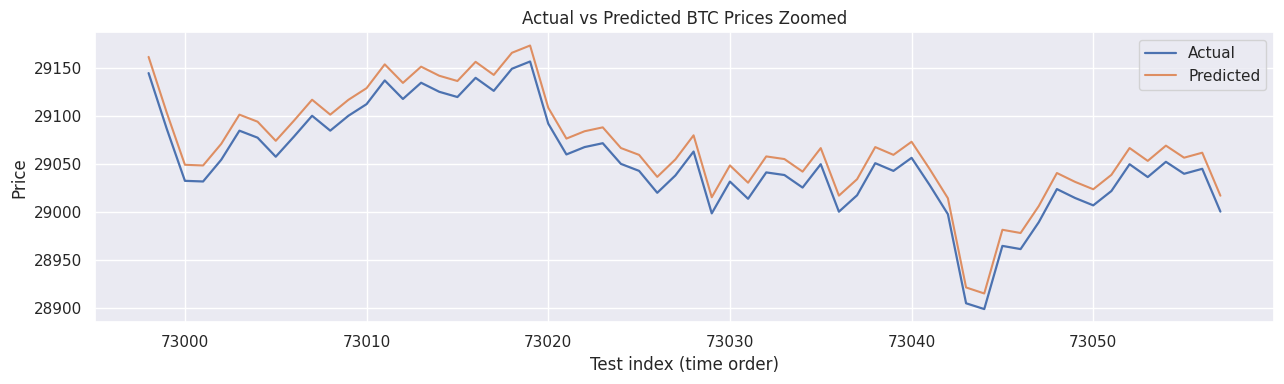

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

In [46]:
# --- Plotting: Actual vs Predicted and direction comparison ---
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Choose how many recent test points to display
N = 60
if len(actual_price) < N:
    N = len(actual_price)

idx = np.arange(len(actual_price))[-N:]

# 1) Actual vs Predicted prices
plt.figure(figsize=(13,4))
plt.plot(idx, actual_price[-N:], label="Actual", linewidth=1.6)
plt.plot(idx, pred_price[-N:], label="Predicted", alpha=0.9)
plt.title(f"Actual vs Predicted BTC Prices Zoomed")
plt.ylabel("Price")
plt.xlabel("Test index (time order)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Direction comparison (step plot: UP vs DOWN)
plt.figure(figsize=(15,6))